Задачей проекта является построение модели банковского скоринга по имеющимся данным.

План решения проекта:
1. Первичный осмотр данных (графики пропусков в данных, графики зависимости целевой переменной от признаков)
2. EDA: поиск и заполнение/удаление пропусков, поиск и удаление выбросов, построение матрицы корреляций признаков
3. Построение самой первой наивной модели (baseline для будующих сравнений)
4. Определение важности признаков
5. Эксперименты (логарифмирование числовых значений, новые обработки признаков, создание новых признаков, нормализация)
7. Выбор метрик и гиперпараметров
8. Повторить пункты 4-7

ЕДА - это просто, когда используешь Pandas Profiling!
https://github.com/testdriver87/sf_rds_projects/tree/master/rds_06 

Как пользоваться Pandas Profiling?
https://habr.com/ru/company/ruvds/blog/451478/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
def default_boxplot(df, num_cols):
    for column in num_cols:
        plt.figure(figsize=(10,5))
        sns.boxplot(x=df.default, y=df[column])
    
    
def histograms(df, num_cols):
    for column in num_cols:
        plt.figure(figsize=(10,5))
        sns.distplot(df[column], kde=False, rug=False) # kde -- кривая плотности распределения; rug -- штрихи на оси абцисс
        
        
def initial_info(df, cols):
    for column in cols:
        plt.figure(figsize=(10, 5))
        sns.distplot(df[column][df.default==1], rug=False, kde=True, label='default')
        sns.distplot(df[column][df.default==0], rug=False, kde=True, label='no_default')
        plt.legend()
        plt.show()

## 1. Первичный осмотр данных

In [3]:
df = pd.read_csv('train.csv')
df.drop('client_id', axis=1, inplace=True)
display(df.info())
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   education         73492 non-null  object
 1   sex               73799 non-null  object
 2   age               73799 non-null  int64 
 3   car               73799 non-null  object
 4   car_type          73799 non-null  object
 5   decline_app_cnt   73799 non-null  int64 
 6   good_work         73799 non-null  int64 
 7   bki_request_cnt   73799 non-null  int64 
 8   home_address      73799 non-null  int64 
 9   work_address      73799 non-null  int64 
 10  income            73799 non-null  int64 
 11  foreign_passport  73799 non-null  object
 12  default           73799 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 7.3+ MB


None

education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

In [4]:
# Заменим пропуски на самый популярный вариант в колонке
df.education.fillna('SCH', inplace=True)

<AxesSubplot:xlabel='default', ylabel='count'>

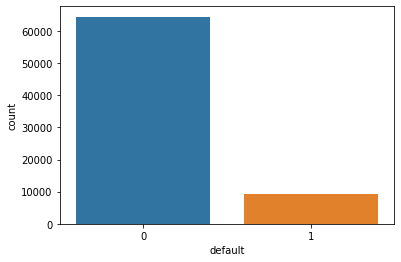

In [5]:
sns.countplot(x=df.default, data=df)
# Заметен дизбаланс целевой переменной

In [6]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

cat_cols = ['education', 'work_address', 'home_address']

num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

edu_dict = {'SCH':1, 'GRD':2, 'UGR':3, 'PGR':4, 'ACD':5}

In [7]:
OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values).shape

(73799, 11)

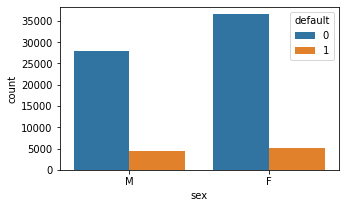

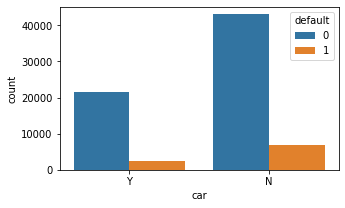

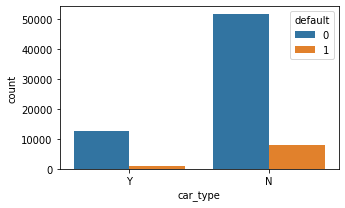

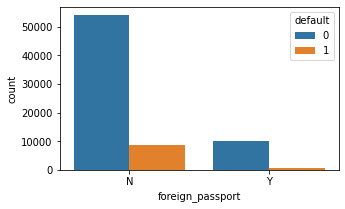

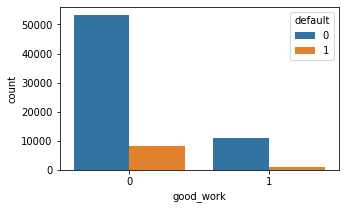

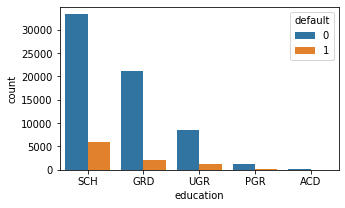

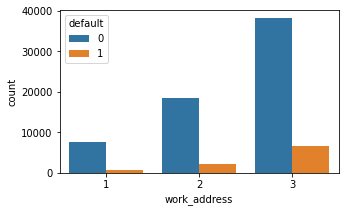

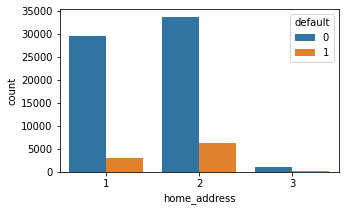

In [8]:
# Графики количества клиентов разного типа для категориальных и бинарных колонок
for column in bin_cols + cat_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(x=df[column], data=df, hue='default')

## 2. EDA

### 2.1 num_cols. Логарифмирование и стандартизация

In [9]:
for column in num_cols:
    print(column.upper())
    display(df[column].describe())
    print('====================')

AGE


count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64

DECLINE_APP_CNT


count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64

BKI_REQUEST_CNT


count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         53.000000
Name: bki_request_cnt, dtype: float64

INCOME


count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

В числовых колонках нет выбросов, но есть экстремальные значения. Возможно, некоторые из них стоит обработать и перевести в категориальные переменные. Например, разбить уровень зарплат на несколько категорий.

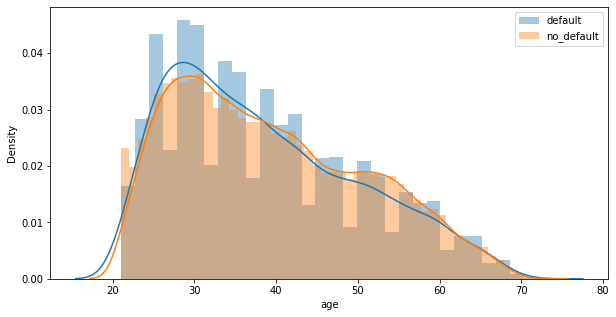

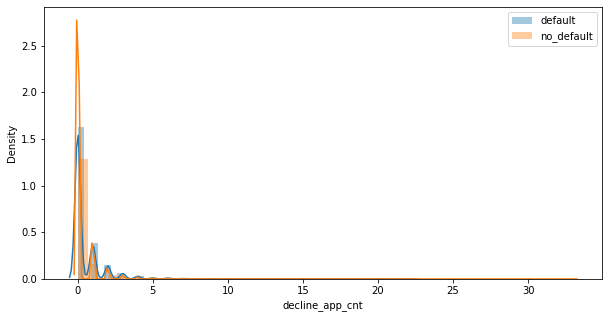

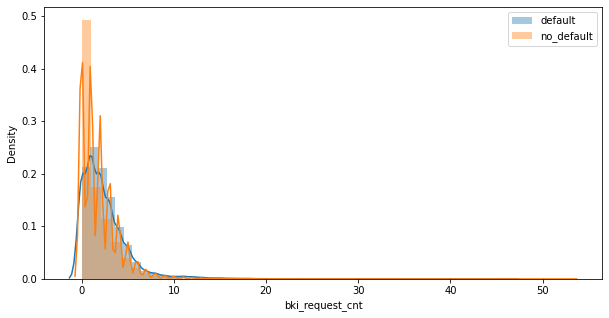

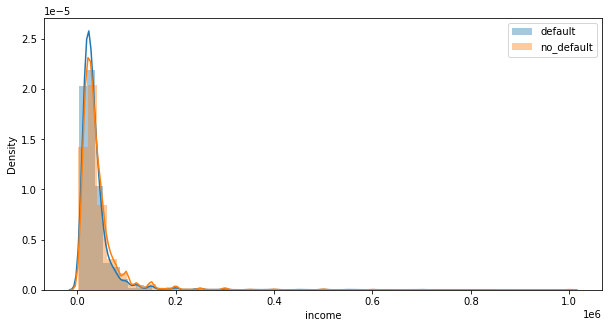

In [10]:
initial_info(df, num_cols);
# Явных отличий между классами дефотлтных и недефолтных клиентов относительно числовых колонок не наблюдается
# Можно отметить, что недефолтными клиентами чаще становятся люди, которые до этого ни тразу не обращались в кредитные организации

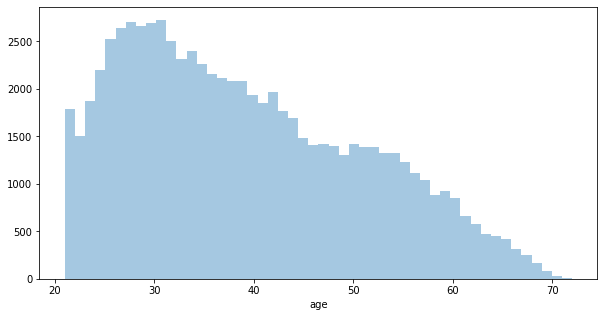

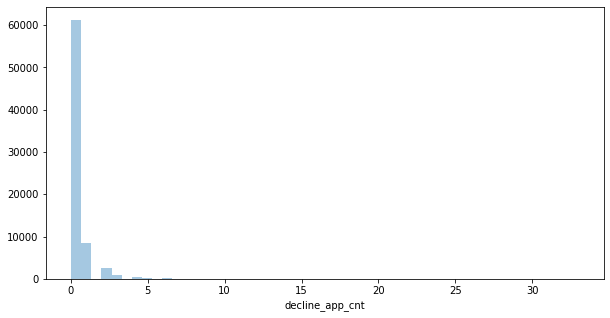

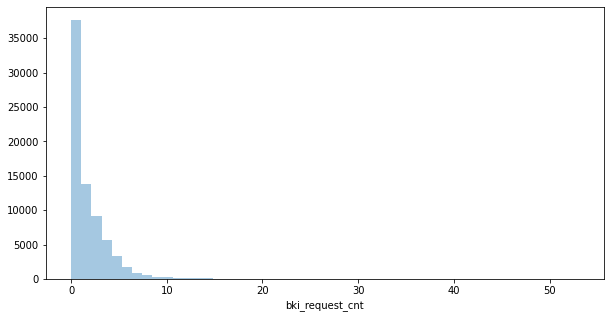

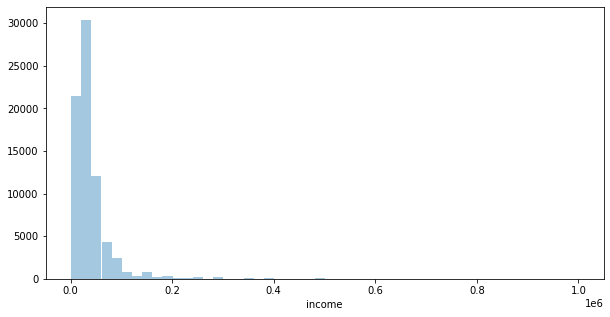

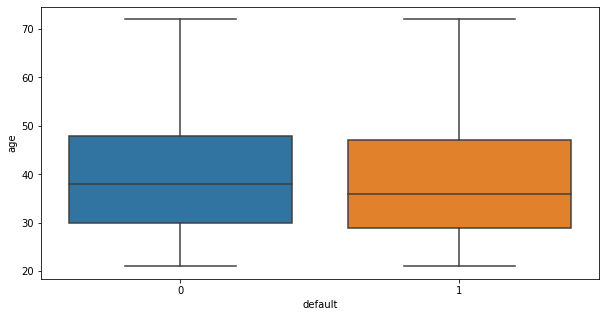

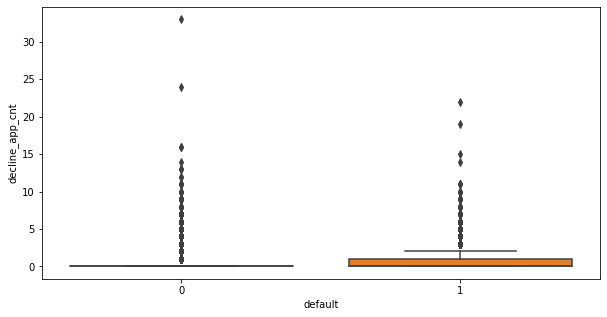

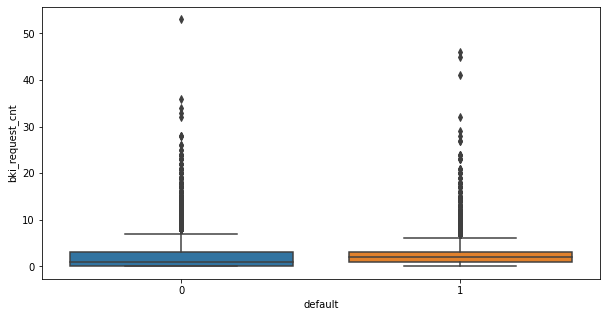

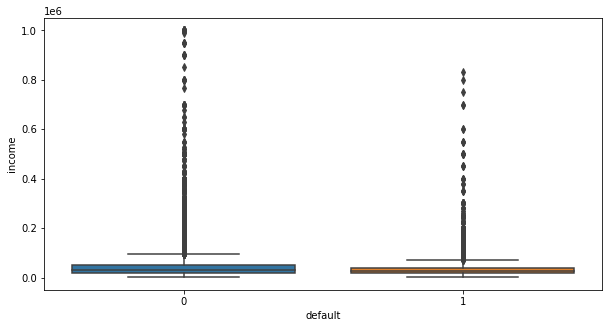

In [11]:
histograms(df, num_cols)
    
default_boxplot(df, num_cols);

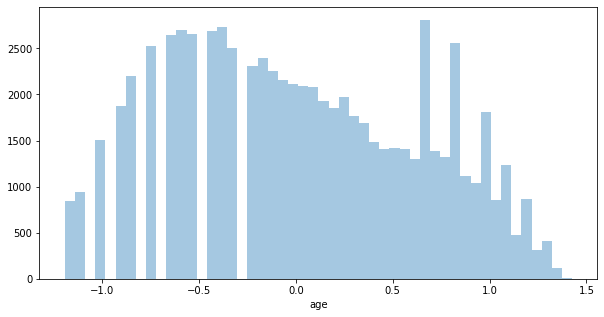

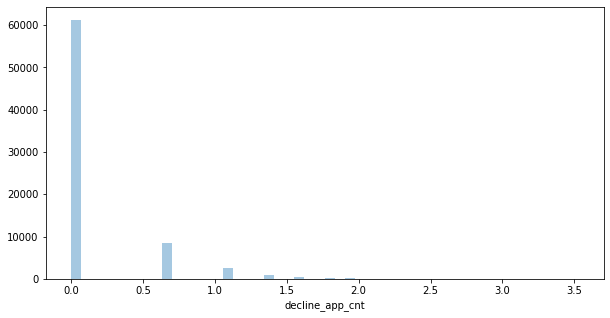

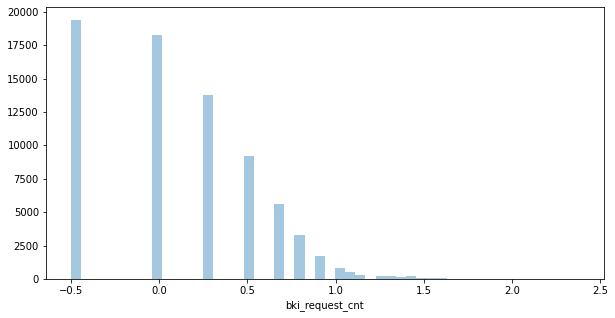

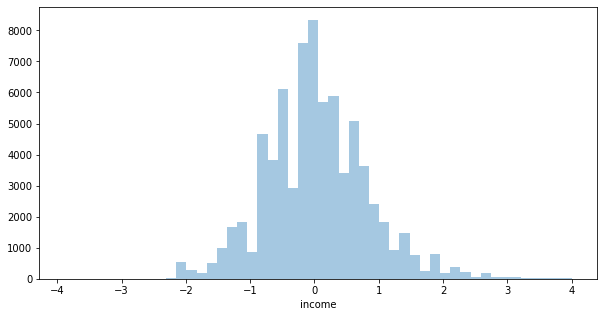

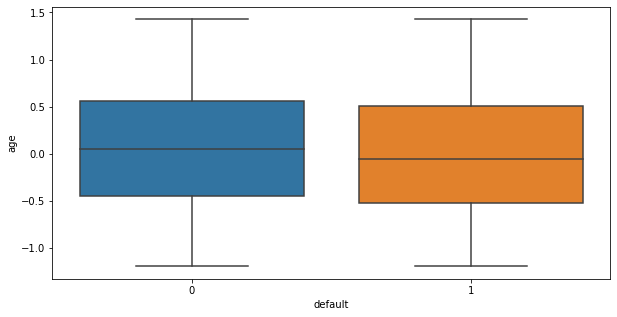

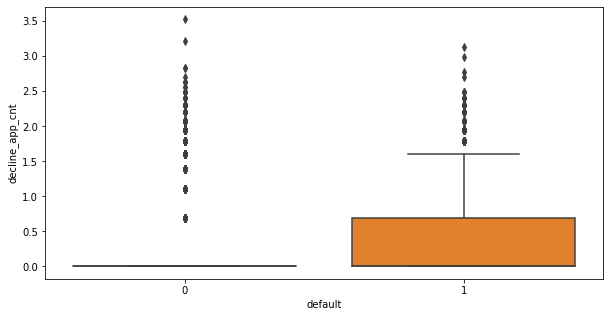

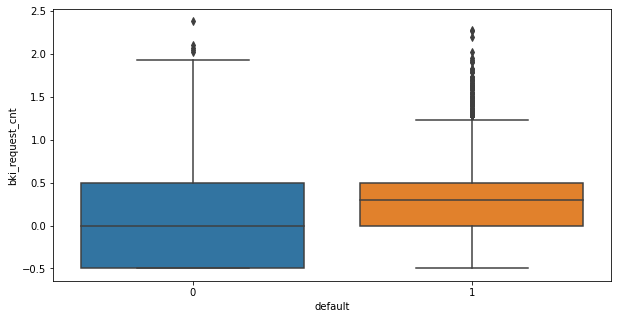

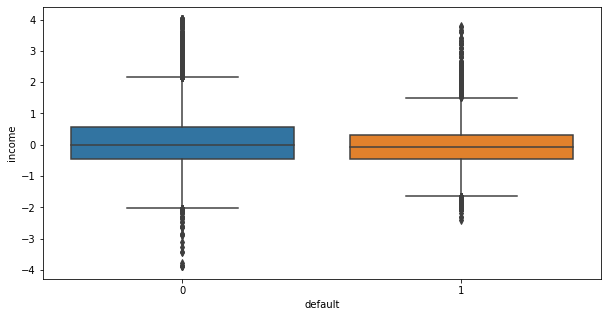

In [12]:
# Необходимо провести логарифмирование и стандартизацию, иначе при построении модели на "сырых" данных получим расходимость метода
# оптимизации, что приведет ко всем нулевым значениям в y_pred

scaler = RobustScaler()

for column in num_cols:
    df[column] = df[column].apply(lambda x: np.log(x + 1))
    df[column] = scaler.fit_transform(df[column][:, np.newaxis])

histograms(df, num_cols)
    
default_boxplot(df, num_cols)

In [13]:
df.head(5)

,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,SCH,M,1.104220,Y,Y,0.000000,0,0.000000,1,2,-0.583482,N,0
1,SCH,F,0.997653,N,N,0.000000,0,0.500000,2,3,-0.521725,N,0
2,SCH,M,-0.828882,Y,N,1.098612,0,0.000000,1,2,0.000000,Y,0
3,SCH,F,0.767524,N,N,0.000000,0,0.292481,2,3,-1.254850,N,0
4,GRD,M,0.555299,N,N,0.000000,1,0.000000,2,3,0.000000,Y,0


### 2.2 bin_cols. Перевод номинативных колонок в числовые

In [14]:
df.head(5)

,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,SCH,M,1.104220,Y,Y,0.000000,0,0.000000,1,2,-0.583482,N,0
1,SCH,F,0.997653,N,N,0.000000,0,0.500000,2,3,-0.521725,N,0
2,SCH,M,-0.828882,Y,N,1.098612,0,0.000000,1,2,0.000000,Y,0
3,SCH,F,0.767524,N,N,0.000000,0,0.292481,2,3,-1.254850,N,0
4,GRD,M,0.555299,N,N,0.000000,1,0.000000,2,3,0.000000,Y,0


In [15]:
label_encoder = LabelEncoder()
print(bin_cols)

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# print(dict(enumerate(label_encoder.classes_))) # посмотреть закодированные признаки
df.head(5)

['sex', 'car', 'car_type', 'foreign_passport', 'good_work']


,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,SCH,1,1.104220,1,1,0.000000,0,0.000000,1,2,-0.583482,0,0
1,SCH,0,0.997653,0,0,0.000000,0,0.500000,2,3,-0.521725,0,0
2,SCH,1,-0.828882,1,0,1.098612,0,0.000000,1,2,0.000000,1,0
3,SCH,0,0.767524,0,0,0.000000,0,0.292481,2,3,-1.254850,0,0
4,GRD,1,0.555299,0,0,0.000000,1,0.000000,2,3,0.000000,1,0


### 2.3. cat_cols. Обработка столбца education

In [16]:
df.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,SCH,1,1.104220,1,1,0.000000,0,0.000000,1,2,-0.583482,0,0
1,SCH,0,0.997653,0,0,0.000000,0,0.500000,2,3,-0.521725,0,0
2,SCH,1,-0.828882,1,0,1.098612,0,0.000000,1,2,0.000000,1,0
3,SCH,0,0.767524,0,0,0.000000,0,0.292481,2,3,-1.254850,0,0
4,GRD,1,0.555299,0,0,0.000000,1,0.000000,2,3,0.000000,1,0


In [17]:
df.education = df.education.apply(lambda x: edu_dict[x])
df.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,1,1,1.104220,1,1,0.000000,0,0.000000,1,2,-0.583482,0,0
1,1,0,0.997653,0,0,0.000000,0,0.500000,2,3,-0.521725,0,0
2,1,1,-0.828882,1,0,1.098612,0,0.000000,1,2,0.000000,1,0
3,1,0,0.767524,0,0,0.000000,0,0.292481,2,3,-1.254850,0,0
4,2,1,0.555299,0,0,0.000000,1,0.000000,2,3,0.000000,1,0


### 2.4 Генерация признаков

Новые признаки: 

1. Income*home_address
2. Income*work_address

По смыслу они описывают вероятность реального получения данной зарплаты 

========================

3. Income/education

Смышленость человека

========================

4. Income/(bki_requests_cnt + 1)
5. Income/(decline_app_cnt + 1)

Вероятность отдать кредит

========================

6. decline_app_cnt*bki_requests_cnt

Мера потребности человека в новом займе

========================

7. home_address*work_address
8. home_address*education
9. work_address*education
10. home_address*work_address*education

«Успешность человека»


In [18]:
feature_num_cols = [f'f{i}' for i in range(1, 6)]
feature_cat_cols = [f'f{i}' for i in range(6, 11)]
feature_num_cols = []
feature_cat_cols = ['f6', 'f8']

In [19]:
#df['f1'] = df['income']*df['home_address']
#df['f2'] = df['income']*df['work_address']
#df['f3'] = df['income']/df['education'] 
#df['f4'] = df['income'] / (df['bki_request_cnt'] + 1) 
#df['f5'] = df['income'] / (df['decline_app_cnt'] + 1) 
df['f6'] = df['decline_app_cnt']*df['bki_request_cnt']
#df['f7'] = df['home_address']*df['work_address']
df['f8'] = df['home_address']*df['education']
#df['f9'] = df['work_address']*df['education']
#df['f10'] = df['home_address']*df['work_address']*df['education']

### 2.4 Посмотрим на корреляцию числовых признаков

<AxesSubplot:>

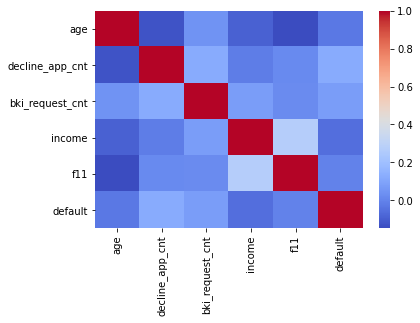

In [20]:
sns.heatmap(df[num_cols + feature_num_cols + ['default']].corr(), cmap='coolwarm')

Числовые признаки слабо кореллируют между собой, что очень хорошо для модели логистической регрессии

### 2.5 Посмотрим на корреляцию всех признаков

<AxesSubplot:>

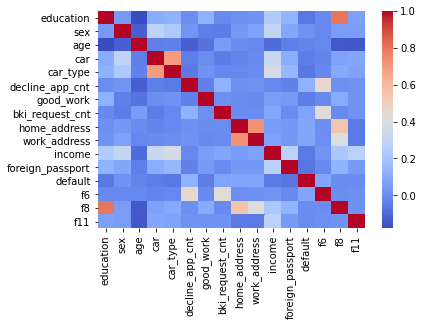

In [21]:
sns.heatmap(df.corr(), cmap='coolwarm')

Корреляция между столбцами car и car_type примерно 0.7
Это значит, что если у заемщика есть в пользовании атвомобиль, то скорее всего это иномарка.

Также между work_adress и home_adress высокая корреляция. Возможно, для home_adress значения являются категориями элитарности места жительства(центр города с дорогими квартирами/пригород/частный дом). Для work_adress суть рассуждения такая же: бизнес центр/ работа просто в городе/промышленная зона. Именно поэтому между этими колонками высокая корреляция: работа человека определяет его положение в обществе и место, где он живет.

In [22]:
# Определитель матрицы корреляций
np.linalg.det(df.corr())

0.005194974166247914

## 3. Строим самую первую модель

In [23]:
model = LogisticRegression()

X = df.drop('default', axis=1)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, shuffle=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f1 = metrics.f1_score(y_pred, y_test)
precision = metrics.precision_score(y_pred, y_test)
recall = metrics.recall_score(y_pred, y_test)

print(' f1 : {}\n precision : {}\n recall : {}'.format(f1, precision, recall))

 f1 : 0.004427227448810182
 precision : 0.0022197558268590455
 recall : 0.8


#### Логарифмирование + масштабирование числовых признаков 
 1. f1 : 0.005122575923893157
 2. precision : 0.0025744759102611253
 3. recall : 0.5
 
#### Исключение признаков bki_request_cnt, decline_app_cnt
 1. f1 : 0.0
 2. precision : 0.0
 3. recall : 0.0
 
#### Разделение признаков bki_request_cnt, decline_app_cnt на подкатегории -- плохая идея

#### Создание признаков f1-f10 повысило метрику recall
 1. f1 : 0.0055309734513274336
 2. precision : 0.002774694783573807
 3. recall : 0.8333333333333334

### Значимость непрерывных переменных

<AxesSubplot:>

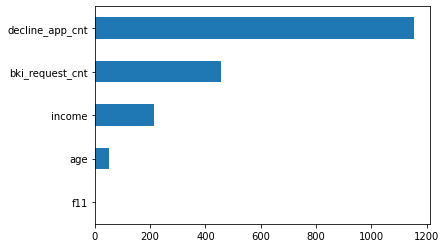

In [24]:
imp_num = pd.Series(f_classif(df[num_cols + feature_num_cols], df['default'])[0], index = num_cols + feature_num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Значимость категориальных признаков

<AxesSubplot:>

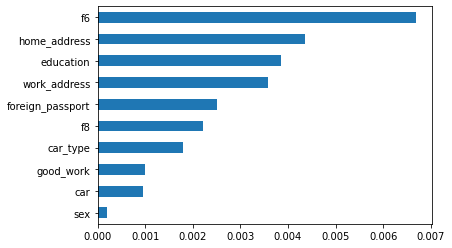

In [25]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols + feature_cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols + feature_cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')